In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_Sigmainv, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.bayes import logPr_bayes, logPr_laplace, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from models import LS, CG

LS Hessian underpredicts errors by far (see line plots and frequentist). Really is the error for LS fit to the mean, which is narrow, doesn't account for deviations from the mean in the true values.

LS $\sigma_s$ more reasonable, but struggles with correlated errors (as expected)

CG Hessian closer but underpredicts vs frequentist error by ~50-80%

In [393]:
nk = nk_dead_live(500, 500)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)

### **LS errors**

In [242]:
like = simple
X = generate_Xs(nk)
theta_true = 10
yl = like.func(X, theta_true)
ls = LS(yl, like, mean_X)
theta_l = ls.minimise(theta_true)
Hl = ls.hess(theta_l)
stdl = np.sqrt(-1/Hl[0,0])

(-0.94, -0.93)

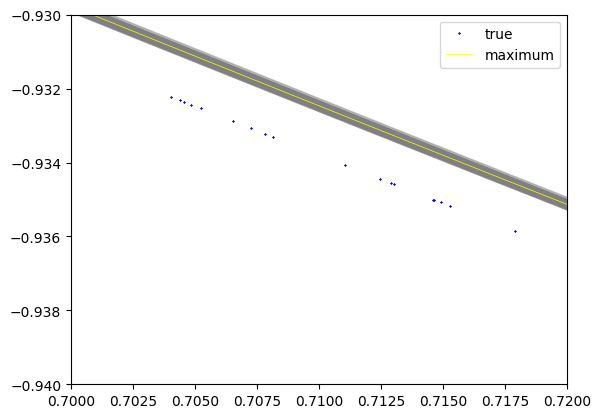

In [208]:
for i in range(200):
    theta = np.random.normal(theta_l, stdl)
    Xl = like.inverse(yl, theta)
    plt.plot(Xl, yl, lw=1, color='gray', alpha=.5)
plt.plot(X, yl, 'x', ms=1, color='blue', label='true')
plt.plot(like.inverse(yl, theta_l), yl, lw=.5, color='yellow', label='maximum')
plt.legend();
plt.xlim(0.7, 0.72);
plt.ylim(-.94, -.93)

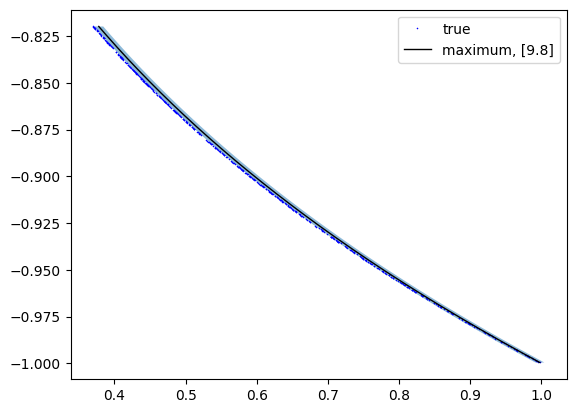

In [207]:
sl = ls.s(theta_l)
Xl = like.inverse(yl, theta_l)
plt.plot(X, yl, 'x', ms=.5, color='blue', label=f'true')
plt.plot(Xl, yl, lw=1, color='black', label=f'maximum, {np.round(theta_l, 2)}')
plt.fill_betweenx(yl, Xl+sl, Xl-sl, alpha=0.5)
plt.legend();
# plt.xlim(0.7, 0.72);
# plt.ylim(-.94, -.93)

### **CG errors**

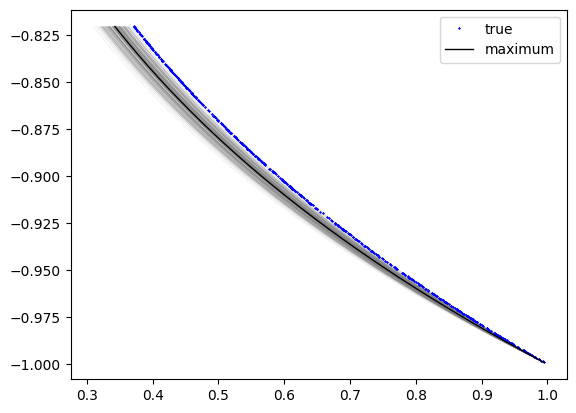

In [241]:
like = simple
X = generate_Xs(nk)
theta_true = 10
y = like.func(X, theta_true)
cg = CG(y, like, mean_X, covinv_X)
theta_c = cg.minimise(theta_true)
Hc = cg.hess(theta_c)
stdc = np.sqrt(-1/Hc)

for i in range(200):
    theta, = np.random.normal(theta_c, stdc)
    Xc = like.inverse(y, theta)
    plt.plot(Xc, y, lw=0.1, color='gray', alpha=0.8)
plt.plot(X, y, 'x', ms=1, color='blue', label='true')
plt.plot(like.inverse(y, theta_c), y, lw=1, color='black', label='maximum')
plt.legend();
# plt.xlim(0.7, 0.72);
# plt.ylim(-.94, -.93)

### **Frequentist errors**

In [217]:
like = simple
X = generate_Xs(nk)
theta_true = 10
yl = like.func(X, theta_true)
ls = LS(yl, like, mean_X)
cg = CG(yl, like, mean_X, covinv_X)
theta_l, theta_c = ls.minimise(theta_true), cg.minimise(theta_true)
Hc = cg.hess(theta_c)
Hl = ls.hess(theta_l)
stdc, stdl = np.sqrt(-1/Hc), np.sqrt(-1/Hl[0,0])
stdc, stdl

(array([[0.3997761]]), 0.009881250007897977)

In [218]:
theta_ls = []
theta_cg = []
for i in range(50):
    X = generate_Xs(nk)
    theta_true = 10
    yl = like.func(X, theta_true)
    ls = LS(yl, like, mean_X)
    cg = CG(yl, like, mean_X, covinv_X)
    theta_ls.append(ls.minimise(theta_true))
    theta_cg.append(cg.minimise(theta_true))
print(np.mean(theta_ls), np.std(theta_ls))
print(np.mean(theta_cg), np.std(theta_cg))

9.99349365234375 0.5086019869839072
10.016689453125 0.5757895326937378


In [212]:
ys = simple.func(X, theta_true)
ls = LS(ys, simple, mean_X)
cg = CG(ys, simple, mean_X, covinv_X)
ls.minimise(10), cg.minimise(10)

(array([9.72039795]), array([9.74603271]))

### **Full likelihood**

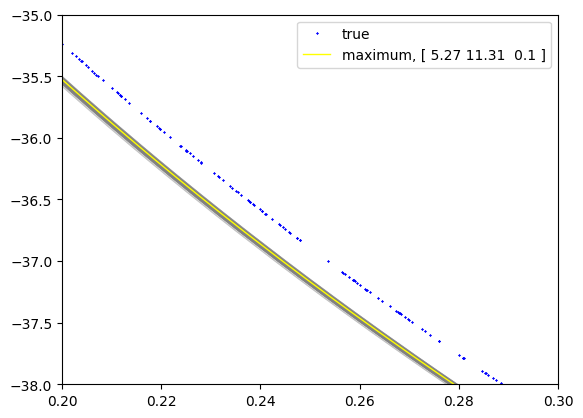

In [419]:
like = full
X = generate_Xs(nk)
theta_true = [1, 10, 0.1]
y = like.func(X, theta_true)
ls = LS(y, like, mean_X)
theta_l = ls.minimise(theta_true)
Hl = ls.hess(theta_l)
covl = np.linalg.inv(-Hl[:3,:3])

for i in range(100):
    theta = np.random.multivariate_normal(theta_l, covl)
    Xl = like.inverse(y, theta)
    plt.plot(Xl, y, lw=.5, color='gray', alpha=.5)
plt.plot(X, y, 'x', ms=1, color='blue', label='true')
plt.plot(like.inverse(y, theta_l), y, lw=1, color='yellow', label=f'maximum, {np.round(theta_l, 2)}')
plt.legend();
plt.xlim(0.2, 0.3);
plt.ylim(-38, -35);

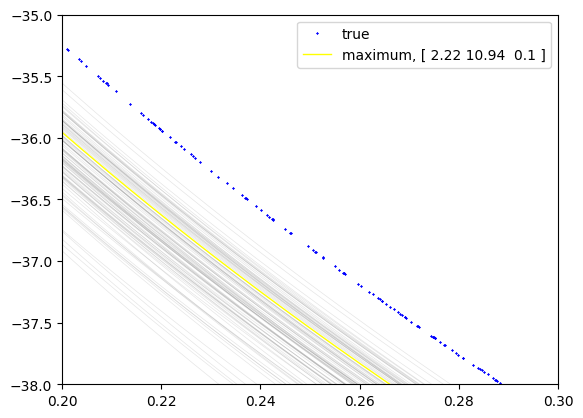

In [430]:
like = full
X = generate_Xs(nk)
theta_true = [1, 10, 0.1]
y = like.func(X, theta_true)
cg = CG(y, like, mean_X, covinv_X)
theta_c = cg.minimise(theta_true)
Hc = cg.hess(theta_c)
covc = np.linalg.inv(-Hc[:3,:3])

for i in range(100):
    theta = np.random.multivariate_normal(theta_c, covc)
    Xl = like.inverse(y, theta)
    plt.plot(Xl, y, lw=.5, color='gray', alpha=.2)
plt.plot(X, y, 'x', ms=1, color='blue', label='true')
plt.plot(like.inverse(y, theta_c), y, lw=1, color='yellow', label=f'maximum, {np.round(theta_c, 2)}')
plt.legend();
# plt.xlim(0.7, 0.72);
# plt.yim(-.94, -.93)
plt.xlim(-0.1,1);
plt.xlim(0.2, 0.3);
plt.ylim(-38, -35);